In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib.colors import ListedColormap
from matplotlib.transforms import Bbox
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.colors import TwoSlopeNorm
import numpy as np
from qutip import wigner, Qobj, destroy

class RemainderFixed(axes_size.Scaled):
    def __init__(self, xsizes, ysizes, divider):
        self.xsizes =xsizes
        self.ysizes =ysizes
        self.div = divider

    def get_size(self, renderer):
        xrel, xabs = axes_size.AddList(self.xsizes).get_size(renderer)
        yrel, yabs = axes_size.AddList(self.ysizes).get_size(renderer)
        bb = Bbox.from_bounds(*self.div.get_position()).transformed(self.div._fig.transFigure)
        w = bb.width/self.div._fig.dpi - xabs
        h = bb.height/self.div._fig.dpi - yabs
        return 0, min([w,h])

def make_square_axes_with_colorbar(ax, size=0.1, pad=0.1):
    """ Make an axes square, add a colorbar axes next to it, 
        Parameters: size: Size of colorbar axes in inches
                    pad : Padding between axes and cbar in inches
        Returns: colorbar axes
    """
    divider = make_axes_locatable(ax)
    margin_size = axes_size.Fixed(size)
    pad_size = axes_size.Fixed(pad)
    xsizes = [pad_size, margin_size]
    yhax = divider.append_axes("right", size=margin_size, pad=pad_size)
    divider.set_horizontal([RemainderFixed(xsizes, [], divider)] + xsizes)
    divider.set_vertical([RemainderFixed(xsizes, [], divider)])
    return yhax
    
def density_plot_v2(rho1,rho2,N,padx=2,pady=0,padcb=0.05,fonttype="",saveas="",cmap = plt.cm.viridis,fontsize=16,dpi=150,color_samples = 1000):
    """
    Computes the wigner function of two given density matrixes and plots them as two density plots next to eachother in the Hilber subspace.
    This function includes number of adjustable parameters to optimize state visualization

    Parameters
    ----------
    rho1,rho2 : ndarray of (dim, dim) shape
        A density matrix to be plotted

    N : integer
        Dimension of the Hilbert subspace used for plotting
    
    padx, pady : integer
        Defines the distance between tick and tick labels
    
    saveas : str
        Name of the file which will the figure saved in including suffix (e.g .png, .pdf) 
    
    cmap : Matplotlib.colormap
        Defines color map to be used in the plot
    
    fontsize : integer
        Defines the size of the font of labels and axis ticks
        
     dpi : integer
        Defines the dpi of the figure when exported
        
    """
    aspect = 0.45
    color_off=0
    color_low_off=-0.3
    color_high_off=0
    color_center = 0
    
    if (fonttype !="" and fonttype !="Tex"):
        plt.rcParams["font.family"] = f'{fonttype}'
    if fonttype == "Tex":    
        plt.rcParams['text.usetex'] = True
    
    def my_map(number):
        result = (number - min_height) * color_norm
        if (result <= 1 and result >= 0):
            return result
        else:
            raise Exception("Number is not in the domain of the function") 
    
    samples = np.linspace(-N,N,200)
    x, p = np.meshgrid(samples, samples)
    # Computing the Wigner function of the state
    Wig_res1 = wigner(Qobj(rho1),samples,samples)
    Wig_res2 = wigner(Qobj(rho2),samples,samples)
    
    min_height = min(np.min(Wig_res1),np.min(Wig_res2))
    max_height = max(np.max(Wig_res1),np.max(Wig_res2))
    #print(np.max(Wig_res1),np.max(Wig_res2))
    norm = TwoSlopeNorm(vmin=min_height, vcenter=color_center, vmax=max_height)
    
    color_norm = 1/(max_height-min_height)
    
    # set up a figure with defined aspect ratio
    fig = plt.figure(figsize=plt.figaspect(aspect), dpi=100)
    
    # =============
    # First subplot
    # =============
    # set up the axes for the first plot
    ax = fig.add_subplot(1, 2, 1)
    #cax = make_square_axes_with_colorbar(ax, size=0.0, pad=0.1)
    range_low = my_map(np.min(Wig_res1))
    range_high = my_map(np.max(Wig_res1))
    color_center = -0.0075
    norm = TwoSlopeNorm(vmin=np.min(Wig_res2), vcenter=color_center, vmax=np.max(Wig_res2))
    new_cmap = ListedColormap(cmap(np.linspace(range_low-color_low_off,range_high+color_high_off,color_samples,100)-color_off))

    im = ax.contourf(x, p, Wig_res1, 100,cmap=cmap,norm=norm)
    #im = ax.contourf(x, p, Wig_res1, 100,cmap=new_cmap,norm=norm)
    ax.set_aspect('equal')
    #plt.plot(tez_b[0],tez_b[1],'r.')
    #plt.xticks(fontsize=fontsize)
    #plt.yticks(fontsize=fontsize)
    ax.tick_params('x', labelsize=fontsize, pad=padx)
    ax.tick_params('y', labelsize=fontsize, pad=pady)
    ax.set_ylabel('p', fontsize=fontsize+4,labelpad=pady+pady)
    ax.set_xlabel('x', fontsize=fontsize+4,labelpad=padx+padx)
    #cb = plt.colorbar(im,pad = 0.05,ticks=[0.3, 0.2, 0.1, 0, -0.1, -0.2],cax=cax)
    #cb.ax.tick_params(labelsize=fontsize)
    #ax.tight_layout()
            
    # ==============
    # Second subplot
    # ==============
    # set up the axes for the second plot
    ax = fig.add_subplot(1, 2, 2)
    # https://github.com/matplotlib/matplotlib/issues/15010
    cax = make_square_axes_with_colorbar(ax, size=0.15, pad=padcb)
    range_low = my_map(np.min(Wig_res2))
    range_high = my_map(np.max(Wig_res2))
    #color_center = -0.003
    #norm = TwoSlopeNorm(vmin=np.min(Wig_res2), vcenter=color_center, vmax=np.max(Wig_res2))
    new_cmap = ListedColormap(cmap(np.linspace(range_low-color_low_off,range_high+color_high_off,color_samples,100)-color_off))

    im = ax.contourf(x, p, Wig_res2, 100,cmap=cmap,norm=norm)
    #im = ax.contourf(x, p, Wig_res2, 100,cmap=new_cmap,norm=norm)
    ax.set_aspect('equal')
    #plt.plot(tez_b[0],tez_b[1],'r.')
    #plt.xticks(fontsize=fontsize)
    #plt.yticks(fontsize=fontsize)
    ax.tick_params('x', labelsize=fontsize, pad=padx)
    ax.tick_params('y', labelsize=fontsize, pad=pady)
    ax.set_ylabel('p', fontsize=fontsize+4,labelpad=pady+pady)
    ax.set_xlabel('x', fontsize=fontsize+4,labelpad=padx+padx)
    cb = plt.colorbar(im,pad = padcb,ticks=[0.3, 0.2, 0.1, 0, -0.1, -0.2],cax=cax)
    cb.ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()
    if saveas !="":
        plt.savefig(f'{saveas}', dpi=dpi,bbox_inches='tight')
    plt.rcParams["font.family"] = 'DejaVu Sans'
    plt.rcParams['text.usetex'] = False
    
def H_evo(N):
    a = destroy(N)
    NUM = a.dag()*a
    return (NUM + 1)

def evolution(rho,t):
    # [:] is present in case you input qutip Qobj which does not have defined length
    N = len(rho[:])
    a = destroy(N)
    NUM = a.dag()*a
    H_evo = (NUM + 1) 
    def U_evo(t):
        return (-1j*H_evo*t).expm()
    ro = U_evo(t)*rho*U_evo(t).dag()
    return ro

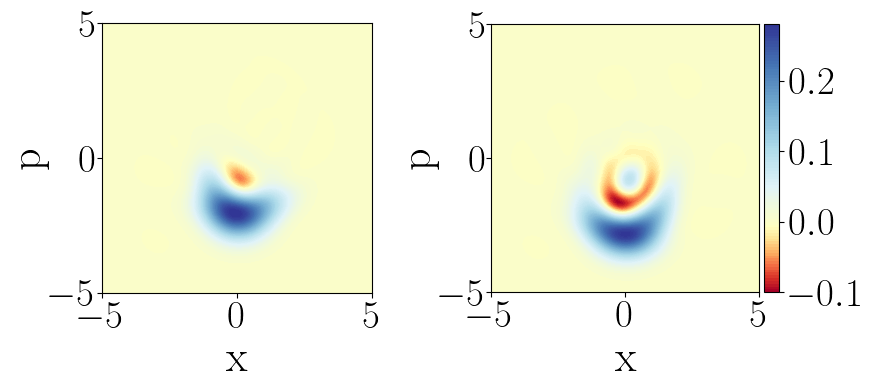

In [10]:
spacs_data = np.load("Git_figure3_spacs_data.npy")
tpacs_data = tpacs2 = np.loadtxt("Git_figure3_tpacs_data.txt", dtype=np.complex128)

spacs_data = evolution(spacs_data,np.pi/2)
tpacs_data = evolution(tpacs_data,np.pi/2)

density_plot_v2(spacs_data,tpacs_data,5,fonttype = "Tex", saveas = "Figure 3.png",dpi=300,cmap=plt.cm.RdYlBu,fontsize = 28)